<a href="https://colab.research.google.com/github/arka57/Hindi-Vowel-Consonant-Classification/blob/main/Hindi_Vowel_Consonant_Classification_LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing libraries

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
cd MyDrive/DL/project/Hindi_Vowel_Consonant

/gdrive/MyDrive/DL/project/Hindi_Vowel_Consonant


In [3]:
ls

test/  test.zip  train/  train.zip


In [ ]:
!unzip train.zip

In [ ]:
!unzip test.zip

In [ ]:
ls

test/  test.zip  train/  train.zip


In [ ]:
#Code for making the image data in tensor form

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms

#For converting the dataset to torchvision dataset format
class VowelConsonantDataset(Dataset):
    def __init__(self, file_path,train=True,transform=None):
        self.transform = transform
        self.file_path=file_path
        self.train=train
        self.file_names=[file for _,_,files in os.walk(self.file_path) for file in files]
        self.len = len(self.file_names)
        if self.train:
            self.classes_mapping=self.get_classes()
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        file_name=self.file_names[index]
        image_data=self.pil_loader(self.file_path+"/"+file_name)
        if self.transform:
            image_data = self.transform(image_data)
        if self.train:
            file_name_splitted=file_name.split("_")
            Y1 = self.classes_mapping[file_name_splitted[0]]
            Y2 = self.classes_mapping[file_name_splitted[1]]
            z1,z2=torch.zeros(10),torch.zeros(10)
            z1[Y1-10],z2[Y2]=1,1
            label=torch.stack([z1,z2])

            return image_data, label

        else:
            return image_data, file_name
          
    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

      
    def get_classes(self):
        classes=[]
        for name in self.file_names:
            name_splitted=name.split("_")
            classes.extend([name_splitted[0],name_splitted[1]])
        classes=list(set(classes))
        classes_mapping={}
        for i,cl in enumerate(sorted(classes)):
            classes_mapping[cl]=i
        return classes_mapping

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets

import torchvision.transforms as transforms

import numpy as np
import pandas as pd

train_on_gpu = torch.cuda.is_available()

In [6]:
transform = transforms.Compose([
    transforms.ToTensor()])

In [7]:
#Splitting of data into train,validation and test set

In [8]:
full_data = VowelConsonantDataset("./train",train=True,transform=transform)
train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size

train_data, validation_data = random_split(full_data, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=4, shuffle=True)


In [9]:
test_data = VowelConsonantDataset("./test",train=False,transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4,shuffle=False)

In [10]:
type(train_data)

torch.utils.data.dataset.Subset

In [11]:
dataiter=iter(train_loader)
images,labels=dataiter.next()
print(images.shape)
print(images[0].shape)

torch.Size([4, 3, 64, 64])
torch.Size([3, 64, 64])


In [12]:
#image dimesnion: 3X64X64

In [13]:
#First Model Applied--LeNet

In [14]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.cnn_model=nn.Sequential(
            nn.Conv2d(3,6,(5,5)),               #(3,64,64)--->(6,60,60)
            nn.AvgPool2d(2,stride=2),           #(6,60,60)--->(6,30,30)
            nn.ReLU(),
            nn.Conv2d(6,16,(5,5)),              #(6,30,30)--->(16,26,26)
            nn.AvgPool2d(2,stride=2),           #(16,26,26)--->(16,13,13)
            nn.ReLU()

        )
        self.vowel_model=nn.Sequential(         #Vowel part--fully connected layers
            nn.Linear(2704,256),
            nn.ReLU(),
            nn.Linear(256,120),
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,10)
        )    
        self.consonant_model=nn.Sequential(     #Consonant part--fully connected layers
            nn.Linear(2704,256),
            nn.ReLU(),
            nn.Linear(256,120),
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,10)
        )  

    def forward(self,x):
        x=self.cnn_model(x)
        x=x.view(x.size(0),-1)
        v1=self.vowel_model(x)
        c1=self.consonant_model(x)
        return v1,c1                        #returning vowel,consonant




        

In [31]:
#Learning Algo


for j,data in enumerate(train_loader,0):
    if(j==1):
        images,labels=data
        print(images.type)
        break    
#print(data[0])    

<built-in method type of Tensor object at 0x7f065e992e90>


In [16]:
print(data[0].shape)

torch.Size([4, 3, 64, 64])


In [17]:
print(images[0].shape)
print(labels[0].shape)

torch.Size([3, 64, 64])
torch.Size([2, 10])


In [18]:
for _,i in enumerate(labels,0):
    vowel,consonant=i

In [19]:
print(vowel.shape)
print(consonant.shape)

torch.Size([10])
torch.Size([10])


In [20]:
print(vowel)

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


In [21]:
#instantiating network

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [23]:
net=LeNet().to(device)
opt=optim.Adam(net.parameters(),weight_decay=0.01)
loss_fn=nn.CrossEntropyLoss()

In [24]:
#Evaluation Function

In [28]:
def evaluation(dataloader):
    total=0
    correct=0
    for i in dataloader:
        images,labels=i
        #print("images shape:",images.shape)
        #print("labels shape",labels.shape)
        images,labels=images.to(device),labels.to(device)
        

        vowel_label,consonant_label=labels[:,0,:],labels[:,1,:]
        _,vowel_label=torch.max(vowel_label,1)
        _,consonant_label=torch.max(consonant_label,1)
        #print("vowel_label shape",vowel_label.shape)
        #print("consonant_label shape",consonant_label.shape)    
        vowel,consonant=net(images)
        #print("vowel shape",vowel.shape)
        #print("consonant shape",consonant.shape) 
        _,vowel_pred=torch.max(vowel,1)
        _,consonant_pred=torch.max(consonant,1)
        #print("vowel_pred shape",vowel_pred.shape)
        #print("consonant_pred shape",consonant_pred.shape) 
        total+=labels.size(0)
        correct_v=(vowel_pred==vowel_label)
        correct_c=(consonant_pred==consonant_label)
        correct+=(correct_v+correct_c).sum().item()
    return (correct/total)*100

In [25]:
def evaluation(dataloader):
    total=0
    correct=0
    for i in dataloader:
        images,labels=i
        images,labels=images.to(device),labels.to(device)
        for j in labels:
            vowel_label,consonant_label=j
        vowel,consonant=net.forward(images)
        _,vowel_pred=torch.max(vowel,1)
        _,consonant_pred=torch.max(consonant,1)
        total+=labels.size(0)
        correct+=((vowel_pred==vowel_label) and (consonant_pred==consonant_label)).sum().item()
    return (correct/total)*100

In [32]:
import copy

In [26]:
#Learning Algo

Loss 4.60
Loss 4.59
Loss 4.61
Loss 4.62
Loss 4.60
Loss 4.61
Loss 4.60
Loss 4.63
Loss 4.61
Loss 4.63
Loss 4.60
Loss 4.62
Loss 4.61
Loss 4.62
Loss 4.62
Loss 4.61
Loss 4.62
Loss 4.61
Loss 4.61
Loss 4.62
Loss 4.59
Loss 4.59
Loss 4.60
Epoch 0/16, Training Accuaracy 19.24, Test Accuracy 16.80
Loss 4.62
Loss 4.60
Loss 4.62
Loss 4.61
Loss 4.62
Loss 4.60
Loss 4.62
Loss 4.61
Loss 4.59
Loss 4.59
Loss 4.61
Loss 4.61
Loss 4.61
Loss 4.60
Loss 4.62
Loss 4.63
Loss 4.61
Loss 4.61
Loss 4.60
Loss 4.63
Loss 4.62
Loss 4.61
Loss 4.62
Epoch 1/16, Training Accuaracy 19.06, Test Accuracy 18.50
Loss 4.62
Loss 4.63
Loss 4.62
Loss 4.61
Loss 4.61
Loss 4.62
Loss 4.59
Loss 4.60
Loss 4.60
Loss 4.61
Loss 4.59
Loss 4.59
Loss 4.61
Loss 4.60
Loss 4.60
Loss 4.60
Loss 4.60
Loss 4.62
Loss 4.57
Loss 4.62
Loss 4.61
Loss 4.59
Loss 4.60
Epoch 2/16, Training Accuaracy 19.11, Test Accuracy 18.00
Loss 4.60
Loss 4.62
Loss 4.62
Loss 4.60
Loss 4.61
Loss 4.61
Loss 4.60
Loss 4.59
Loss 4.60
Loss 4.64
Loss 4.60
Loss 4.63
Loss 4.62
Loss 4

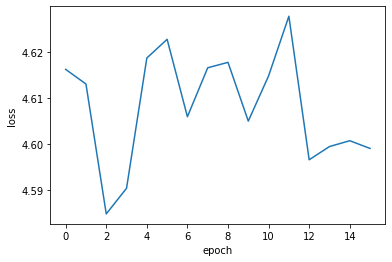

CPU times: user 7min 28s, sys: 38 s, total: 8min 6s
Wall time: 11min 12s


In [33]:
%%time
loss_epoch=[]
epochs=16
min_loss=1000

for i in range(epochs):
    for j,data in enumerate(train_loader,0):
        input,labels=data
        input,labels=input.to(device),labels.to(device)
        #print(input.shape)            #(32,3,224,224)
        #print(labels.shape)           #(32,2,10)
        
        
        vowel_label,consonant_label=labels[:,0,:],labels[:,1,:]
        
        vowel,consonant=net.forward(input)
        #print(vowel_label.shape)      #(32,10)
        #print(consonant_label.shape)  #(32,10)
        #print(vowel.shape)            #(32,10)
        #print(consonant.shape)        #(32,10)
        lossV=loss_fn(vowel,vowel_label)
        lossC=loss_fn(consonant,consonant_label)
        loss=lossV+lossC
        loss.backward()

        opt.step()
        opt.zero_grad()

        if min_loss> loss :
            min_loss=loss
            best_model = copy.deepcopy(net.state_dict())

        if(j%100==0):
            print('Loss %0.2f'%loss.item())
        del vowel,consonant,labels,input
        torch.cuda.empty_cache()
        
    loss_epoch.append(loss.item())
    print('Epoch %d/%d, Training Accuaracy %0.2f, Test Accuracy %0.2f' % (i,epochs,evaluation(train_loader),evaluation(validation_loader))) 

net.load_state_dict(best_model)
plt.plot(loss_epoch)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()